<div style="border-radius: 20px; background-color: #86c7ff; font-family: Roboto Mono;"><h1 style="padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: black;">Understanding CNN part#2</h1></div>
This notebook is the natural sequel of my previous notebook:

[Understanding CNN](https://www.kaggle.com/code/fid0did0/understandig-cnn-layer-by-layer-on-digit-reco)

On That notebook the "features map" was generated when the CNN input was feed with one samples from calss "3", one samples from calss "5" and one samples from calss "1".
The "features map" means the intermediate product generated by the CNN after the "max_pooling2d_2" layer and jut before the last two dense layers.

The final picture generated was this one:
![feature map](https://www.kaggleusercontent.com/kf/120347857/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..QNyFljDXkeZOu_diJKM-Xg.jVcOd-sXIVN9lOB82ua9KCuVIuJmstpmFwodFPwKW0N_3F7k8KxMaZ4J8xMPTWEjRYpdDiXBPAQI_q_PGG6oi1bM4mgeO96e_QGJ0esDyUIYcaecCRhtflpxMnsQLLb2eMDf7OZ70t50fWKZXs1lluhC7gF2uDCvkGHEGb9iwRNBy28GGFXx6N7vGs6S7laQOHMi5T4K8L9v0Dasr1jKSSPmxOxAsKEWmXjbjR-15Rw9NU3xZRup1IhgbWEo2wgQuRqm-orYVLnl5fLVVulf5s4RQWtA8T76XCYJLE9kfNvXgzYG0pD9pbMMD501Hg-8iYaOT7LxfS9aIo9OkrwcwbYDsooFSMwsgx33ywmLupYi_g8n1WysogMzn8-3iURufZ9nOXAWNJnyCmESKW_NxobYr7a_BtuDknMGFaPzAGrANRc37LuXJkR8iZeWCsEG2XsUBdLiiDGBOGDviY6gXOWfciYcPEhBiQqJrEzm8CVbnzWGcJAwW7hs2ZyS7LVdD8s_JXyyIZpeHlncpnNLOJ_dWlvHB1WPIRhmH8KQxMJ3woIXgGhITrihHz5Kv8KF1VXmsyYKYxlhQGeFLHriMNYYQC4kevet3P_a3gSfBXbFTZjWl9zV2sN7Sc4ZKrEp89a9upOo51EYkehbb1D3vBnOGsuzcVPj5Gbnv2FxaFYdi6i7yQTnna0n6qwHvRYY.W3nvq87-w5UsPnxYJg0fUQ/__results___files/__results___27_2.png)

where each one of the 128 pixel shows the output generated at the layer "max_pooling2d_2" output (shape 1,1,1,128). Because I was using three different samples I used the color to differentiate the three results. The red color is used to show the results when the sample of class "3" was feed, the green when feeding with sample of class "5" and blue when feeding with sample of class "1". Yellow, cyan and magenta means that the "feature" was activated by two classes.

In this notebook I'm going to syntesize the "features map" at the same layer ("max_pooling2d_2") required to generate the "pure" output for the class used, to see if the map match the previous one.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras as krs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/refmodel/understand_cnn/saved_model.pb
/kaggle/input/refmodel/understand_cnn/keras_metadata.pb
/kaggle/input/refmodel/understand_cnn/variables/variables.index
/kaggle/input/refmodel/understand_cnn/variables/variables.data-00000-of-00001
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
ref_model=krs.models.load_model('/kaggle/input/refmodel/understand_cnn')
#ref_model.summary()

This time I'm intrested on the last two "dense" layers, the classifier.

In [3]:
classifier = krs.models.Model(inputs=ref_model.get_layer('dropout_2').input, outputs=ref_model.output)
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 128)]       0         
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 128)         0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 35,594
Trainable params: 35,594
Non-trainable p

The strategy used here is to synthesize the "feature map" that maximize the activation of one specific class, or minimize the loss vs the expected target class. This sentence sound like an optimization process, so the gradient descend algorithm wil be perfect to achieve the result. The process will be similar to the process used by the neural network to learn its weights, but now the "trainable parameters" will be the value of the input "feature map" having the layer weight frozen.
To execute this process I'm starting defining a loss function between the "label" generated by the "feature map" feed to the function and the expected ideal target (a vector where all the index are zero but the target class index is one).

At this point I initialize the "feature map" zeroing all the elements.
I'm then evaluating the gradients of the activation loss function versus the activation map elements and finally I'm invoking the optimizer in order to modify the "feature map" in the direction that minimize the loss.
I'm iterating the process for 100 time and repeat the process for the three class used: "3", "5" and "1".


In [4]:
def activation_loss(input_tensor, max_idx):
    target = tf.Variable(tf.zeros(10))
    target=target[max_idx].assign(1)
    label = classifier(input_tensor)
    loss = loss = tf.keras.losses.mean_squared_error(target, label)
    return loss

activation_r = tf.Variable(tf.zeros((1, 1, 1, 128)))
optimizer = tf.optimizers.Adam(learning_rate=0.1)
for i in range(100):
    with tf.GradientTape() as tape:
        act_loss = activation_loss(activation_r, 3)
    gradients = tape.gradient(act_loss, activation_r)
    optimizer.apply_gradients([(gradients, activation_r)])

activation_g = tf.Variable(tf.zeros((1, 1, 1, 128)))
optimizer = tf.optimizers.Adam(learning_rate=0.1)
for i in range(100):
    with tf.GradientTape() as tape:
        act_loss = activation_loss(activation_g, 5)
    gradients = tape.gradient(act_loss, activation_g)
    optimizer.apply_gradients([(gradients, activation_g)])

activation_b = tf.Variable(tf.zeros((1, 1, 1, 128)))
optimizer = tf.optimizers.Adam(learning_rate=0.1)
for i in range(100):
    with tf.GradientTape() as tape:
        act_loss = activation_loss(activation_b, 1)
    gradients = tape.gradient(act_loss, activation_b)
    optimizer.apply_gradients([(gradients, activation_b)])


At this point I can combine the resulted vector in an RGB vector read to be shown as an image.

(-0.5, 31.5, 3.5, -0.5)

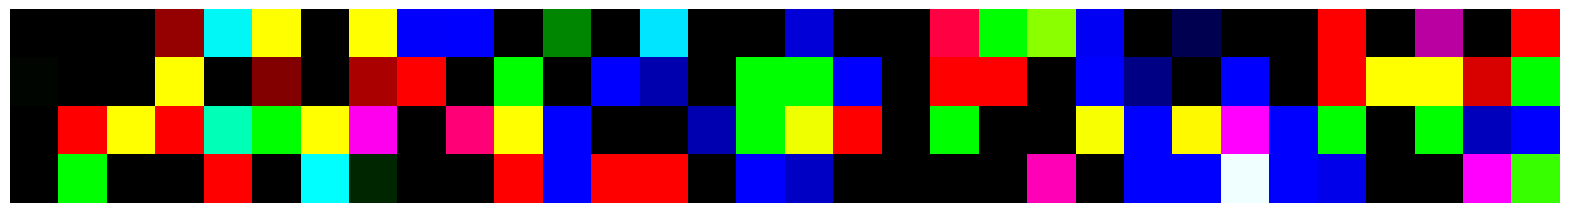

In [5]:
img=np.stack([activation_r.numpy()[0,0,0,:].reshape(4, 32),
              activation_g.numpy()[0,0,0,:].reshape(4, 32),
              activation_b.numpy()[0,0,0,:].reshape(4, 32)], axis=2)
img_min=np.amin(img)
img_max=np.amax(img)
#print(img_min)
#print(img_max)

plt.figure(figsize=(20, 60))
plt.imshow(img, vmin=img_min, vmax=img_max)
plt.axis("off")

Just before to close I want to verify that using the activation map syntesized for a class "3", the CNN really predict a "3". Just to be sure that I didn't make big mistake.

In [6]:
x_ver=activation_r.numpy()
x_ver=x_ver.reshape(1,1,1,128)
print(x_ver.shape)
y_ver = classifier.predict(x_ver)
print(y_ver)

(1, 1, 1, 128)
1/1 [==============================] - 0s 241ms/step
[[4.2387205e-06 2.9287571e-06 2.6298856e-05 9.9937940e-01 1.0079852e-06
  3.2113295e-04 1.4320403e-06 8.2764782e-06 2.1807227e-04 3.7183872e-05]]
